# Resampling with Pyresample and Satpy

This notebook will show all the resampling methods Pyresample offers. Both the usage with direct Pyresample calls and via Satpy `Scene.resample()` are shown.

Set some environment variables for performance tweaking

In [2]:
import os
os.environ['PYTROLL_CHUNK_SIZE'] = "1024"
os.environ['DASK_NUM_WORKERS'] = "4"
os.environ['OMP_NUM_THREADS'] = "1"

Import Satpy, read some data, get the source and target area definitions

In [125]:
from satpy import Scene
from satpy.resample import get_area_def
import glob

fnames = glob.glob("/home/lahtinep/data/satellite/new/*201909031245*")
scn = Scene(reader='seviri_l1b_hrit', filenames=fnames)
scn.load([10.8])
data = scn[10.8]
source_adef = data.attrs['area']
euro4_adef = get_area_def('euro4')
euron1_adef = get_area_def('euron1')

## Nearest neighbour resampling

First, run with plain Pyresample calls

In [60]:
from pyresample.kd_tree import XArrayResamplerNN

In [127]:
resampler = XArrayResamplerNN(source_adef, euron1_adef, radius_of_influence=50e3)
resampler.get_neighbour_info()
res = resampler.get_sample_from_neighbour_info(data)
res_computed = res.compute()

/home/lahtinep/Software/pytroll/packages/pyresample/pyresample/kd_tree.py:1211: PerformanceWarning: Increasing number of chunks by factor of 12
  dtype=new_data.dtype, concatenate=True)


Show the image

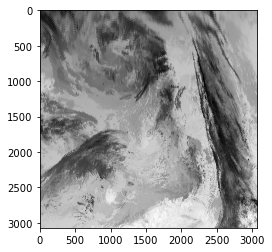

In [128]:
import matplotlib.pyplot as plt
plt.imshow(res_computed, cmap='gray')
plt.show()

Now with Satpy calls. Here we can benefit from storing the resampling look-up tables to a cache directory. To see the performance difference for the initial and subsequent runs, we'll run the same code twice.

In [80]:
%%time
res = scn.resample('euron1', resampler='nearest',
                   radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/nearest.tif')

CPU times: user 8.81 s, sys: 327 ms, total: 9.14 s
Wall time: 8.25 s


In [72]:
%%time
res = scn.resample('euron1', resampler='nearest', radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/nearest.tif')

CPU times: user 8.85 s, sys: 293 ms, total: 9.14 s
Wall time: 8.24 s


## Bilinear resampling

In [78]:
from pyresample.bilinear.xarr import XArrayResamplerBilinear

resampler = XArrayResamplerBilinear(source_adef, euro4_adef,
                                    radius_of_influence=50e3)
resampler.get_bil_info()
res = resampler.get_sample_from_bil_info(data)
res_computed = res.compute()

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in less
  result = function(*args, **kwargs)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in greater
  result = function(*args, **kwargs)


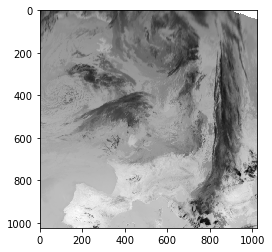

In [79]:
plt.imshow(res_computed, cmap='gray')
plt.show()

In [83]:
%%time
res = scn.resample('euron1', resampler='bilinear',
                   radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/bilinear.tif')

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtine

CPU times: user 12min 52s, sys: 2min 27s, total: 15min 19s
Wall time: 7min 55s


In [84]:
%%time
res = scn.resample('euron1', resampler='bilinear',
                   radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/bilinear.tif')

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in less
  result = function(*args, **kwargs)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in greater
  result = function(*args, **kwargs)


CPU times: user 43.7 s, sys: 4.67 s, total: 48.4 s
Wall time: 19.3 s


## Bucket resamplers

In [129]:
scn = Scene(reader='seviri_l1b_hrit', filenames=fnames)
scn.load(['HRV'])
data = scn['HRV']
source_adef = data.attrs['area']

/home/lahtinep/Software/pytroll/packages/pyresample/pyresample/geometry.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self.pixel_size_y = (area_extent[3] - area_extent[1]) / float(height)


In [130]:
from pyresample.bucket import BucketResampler

lons, lats = source_adef.get_lonlats(chunks=1024)
resampler = BucketResampler(euro4_adef, lons, lats)

In [131]:
import dask.array as da
sums = resampler.get_sum(data)
counts = resampler.get_count()
sums_computed, counts_computed = da.compute(sums, counts)

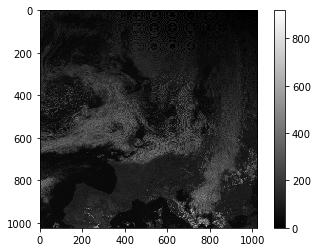

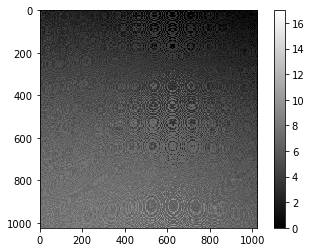

In [175]:
plt.imshow(sums_computed, cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(counts_computed, cmap='gray')
plt.colorbar()
plt.show()

In [133]:
average = resampler.get_average(data)
average_computed = average.compute()

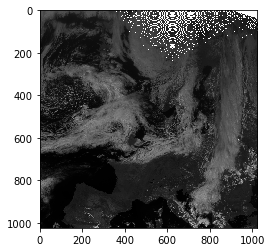

In [134]:
plt.imshow(average_computed, cmap='gray')
plt.show()

In [167]:
binary_data = da.where(data > 60, 1, 0)
fractions = resampler.get_fractions(binary_data, categories=[0, 1])
fractions.keys()

dict_keys([0, 1])

In [168]:
fractions = da.compute(fractions)[0]

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


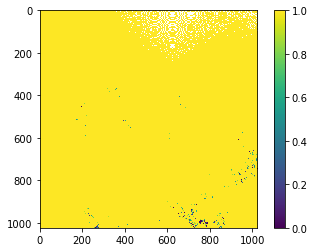

In [174]:
plt.imshow(fractions[0])
plt.colorbar()
plt.show()